In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rho = 1.225 #  masse volumique de l'air [kg/m3]
nu = 15.6E-6 #  viscosité cinématique de l'air [m2/S]

In [2]:
#  Recherche des coefficients de portance et de traînée

#  Profil : Horten Brothers
#  Résultats de soufflerie numérique JavaFoil pour Re=100000

Labels = ['alpha', 'Cl', 'Cd', 'Cm025']

Soufflerie = [
    [0.0, 0.000, 0.01047, -0.000],
    [1.0, 0.117, 0.01054, -0.001],	
    [2.0, 0.237, 0.01089, -0.002],
    [3.0, 0.355, 0.01148, -0.003],
    [4.0, 0.473, 0.01143, -0.004],
    [5.0, 0.587, 0.01544, -0.006],
    [6.0, 0.695, 0.01716, -0.008],
    [7.0, 0.791, 0.01895, -0.012],
    [8.0, 0.840, 0.02194, -0.022],
    [9.0, 0.619, 0.05325, -0.049],
    [10.0, 0.698, 0.05848, -0.053]
]

Soufflerie = pd.DataFrame(Soufflerie, columns=Labels)
Soufflerie

# Effectuons une regression linéaire pour traduire l'évolution de Cl en fonction de alpha
A11, A12, A21, A22 = 0, 0, 0, 0
B1, B2 = 0, 0
for i in range(len(Soufflerie['alpha']) - 3):
    A11 += Soufflerie['alpha'].iloc[i]
    A12 += Soufflerie['alpha'].iloc[i]**2
    A21 += 1
    A22 += Soufflerie['alpha'].iloc[i]
    B1 += Soufflerie['alpha'].iloc[i] * Soufflerie['Cl'].iloc[i]
    B2 += Soufflerie['Cl'].iloc[i]
A = np.array([[A11, A12], [A21, A22]], dtype=float)
B = np.array([[B1], [B2]])
A_inv = np.linalg.inv(A)
Coefs_Cl = np.dot(A_inv, B)

def f_Cl(alpha):
    return Coefs_Cl[1, 0] * alpha + Coefs_Cl[0, 0]

# Effectuons une approximation quadratique de Cd en fonction de Cl
M = np.zeros([3, 3], dtype=float)
Y = np.zeros([3, 1])
for i in range(len(Soufflerie['Cl']) - 3):
    M[0, 0] += 1
    M[0, 1] += Soufflerie['Cl'].iloc[i]
    M[0, 2] += Soufflerie['Cl'].iloc[i]**2
    M[1, 0] += Soufflerie['Cl'].iloc[i]
    M[1, 1] += Soufflerie['Cl'].iloc[i]**2
    M[1, 2] += Soufflerie['Cl'].iloc[i]**3
    M[2, 0] += Soufflerie['Cl'].iloc[i]**2
    M[2, 1] += Soufflerie['Cl'].iloc[i]**3
    M[2, 2] += Soufflerie['Cl'].iloc[i]**4
    Y[0, 0] += Soufflerie['Cd'].iloc[i]
    Y[1, 0] += Soufflerie['Cd'].iloc[i] * Soufflerie['Cl'].iloc[i]
    Y[2, 0] += Soufflerie['Cd'].iloc[i] * Soufflerie['Cl'].iloc[i]**2
M_inv = np.linalg.inv(M)
Coefs_Cd = np.dot(M_inv, Y)

def f_Cd(Cl):
    return Coefs_Cd[0, 0] + Coefs_Cd[1, 0]*Cl + Coefs_Cd[2, 0]*Cl**2

In [5]:
eps = 10**(-5)

rho = 1.225
nu = 15.6E-6
ac = 0.2 #  Glauert's limit

alpha_finesse = 6 #  angle d'incidence correspondant à la finesse maximale du profil
alpha_finesse_rad = alpha_finesse * np.pi/180

R = 1.0 #  rayon de la pale [m]
B = 6 #  nombre de pales
c = 0.10 #  corde du profil [m] (ici la corde est constante le long de la pale)

sigma = B*c/(np.pi*R) #  solidité de l'hélice
lamb = 2.7 #  advance ratio
V0 = 50/3.6
omega = lamb*V0/R

# Calcul de Cl et Cd
Cl = f_Cl(alpha_finesse)
Cd = f_Cd(Cl)

data = []
Cp, Ct = 0, 0
dx = 1/100
dr = R*dx

for i in range(8, 100):
    s = i/100
    r = s * R
    
    c = 0.1*np.sqrt((R-r)/R)
    
    x = lamb*s
    sigma = B*c/(2*np.pi*r)
    
    a, a_ = 0, 0
    
    def compute(a, a_):
        phi_rad = np.arctan((1-a)/((1+a_)*lamb*s))

        alpha_rad = alpha_finesse_rad
        theta_rad = phi_rad - alpha_rad

        Cn = Cl*np.cos(phi_rad) + Cd*np.sin(phi_rad)
        Ct = Cl*np.sin(phi_rad) - Cd*np.cos(phi_rad)

        f = B/2 * (R-r)/r*np.sin(phi_rad)
        F = 2/np.pi * np.arccos(np.exp(-f))
        
        if a < ac:
            n_a = 1/(1 + (4*F*np.sin(phi_rad)**2)/(sigma*Cn))
        else:
            K = 4*F*np.sin(phi_rad)**2/(sigma*Cn)
            n_a = 0.5 * (2 + K*(1-2*ac) - np.sqrt((K*(1-2*ac) + 2)**2 + 4*(K*ac**2 - 1)))
        n_a_ = 1/((4*F*np.sin(phi_rad)*np.cos(phi_rad))/(sigma*Ct) - 1)

        diff = np.sqrt((a - n_a)**2 + (a_ - n_a_)**2)
        
        return diff, n_a, n_a_, phi_rad, alpha_rad, theta_rad, Cl, Cd, Cn, Ct, F
    
    diff, a, a_, phi_rad, alpha_rad, theta_rad, Cl, Cd, Cn, Ct, F = compute(a, a_)
    
    while diff >= eps: 
        diff, a, a_, phi_rad, alpha_rad, theta_rad, Cl, Cd, Cn, Ct, F = compute(a, a_)
        
    phi = phi_rad * 180/np.pi
    alpha = alpha_rad * 180/np.pi
    theta = theta_rad * 180/np.pi
    
    dT = 0.5*rho*B*c*Cn*dr*((1-a)*V0**2)/(np.sin(phi_rad)**2)
    dM = 0.5*rho*B*c*Ct*r*dr*(V0*(1-a)*omega*r*(1+a_))/(np.sin(phi_rad)*np.cos(phi_rad))
    
    data.append([s, r, x, a, a_, F, sigma, c, phi, theta, alpha, Cl, Cd, Cn, Ct, dT, dM, V0, omega, lamb])
    
Propeller = pd.DataFrame(
    data, 
    columns=['s', 'r', 'x', 'a', 'a_', 'F', 'sigma', 'c', 'phi', 'theta', 'alpha', 'Cl', 'Cd', 'Cn', 'Ct', 'dT', 'dM', 'V0', 'omega', 'lamb']
)
print(round(Propeller['dM'].sum()*omega, 2), 'W')
print(round(0.5*rho*np.pi*R**2*V0**3, 2), 'W')
print(round(Propeller['dM'].sum()*omega / (0.5*rho*np.pi*R**2*V0**3) * 100, 2), '%')
Propeller

782.7 W
5155.35 W
15.18 %


,s,r,x,a,a_,F,sigma,c,phi,theta,alpha,Cl,Cd,Cn,Ct,dT,dM,V0,omega,lamb
0,0.08,0.08,0.216,0.094224,0.902634,1.000000,1.144920,0.095917,65.595343,59.595343,6.0,0.69244,0.016788,0.301389,0.623635,0.223837,0.033562,13.888889,37.5,2.7
1,0.09,0.09,0.243,0.084635,0.717367,1.000000,1.012161,0.095394,65.491588,59.491588,6.0,0.69244,0.016788,0.302518,0.623088,0.226189,0.038380,13.888889,37.5,2.7
2,0.10,0.10,0.270,0.077786,0.583800,1.000000,0.905926,0.094868,65.123128,59.123128,6.0,0.69244,0.016788,0.306519,0.621129,0.230985,0.043166,13.888889,37.5,2.7
3,0.11,0.11,0.297,0.072741,0.484465,1.000000,0.818981,0.094340,64.570129,58.570129,6.0,0.69244,0.016788,0.312499,0.618142,0.237605,0.047939,13.888889,37.5,2.7
4,0.12,0.12,0.324,0.068934,0.408656,1.000000,0.746503,0.093808,63.886034,57.886034,6.0,0.69244,0.016788,0.319857,0.614367,0.245638,0.052714,13.888889,37.5,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.95,0.95,2.565,0.175185,0.019731,0.194642,0.022477,0.022361,17.502413,11.502413,6.0,0.69244,0.016788,0.665432,0.192238,0.961918,0.217749,13.888889,37.5,2.7
88,0.96,0.96,2.592,0.179600,0.019680,0.172243,0.019894,0.020000,17.244647,11.244647,6.0,0.69244,0.016788,0.666290,0.189242,0.881864,0.197268,13.888889,37.5,2.7
89,0.97,0.97,2.619,0.184174,0.019634,0.147567,0.017051,0.017321,16.988332,10.988332,6.0,0.69244,0.016788,0.667130,0.186260,0.782834,0.172963,13.888889,37.5,2.7
90,0.98,0.98,2.646,0.188921,0.019592,0.119182,0.013780,0.014142,16.732998,10.732998,6.0,0.69244,0.016788,0.667954,0.183285,0.655235,0.142912,13.888889,37.5,2.7


In [8]:
eps = 10**(-5)

rho = 1.225
nu = 15.6E-6

B = 5
A = 3.8

alpha_finesse = 6 #  angle d'incidence correspondant à la finesse maximale du profil
alpha_finesse_rad = alpha_finesse * np.pi/180

# Calcul de Cl et Cd
Cl = f_Cl(alpha_finesse)
Cd = f_Cd(Cl)

data = []
DF = []
Cp = 0
dx = 1/500

def F(A, theta, B, x):
    Cn = Cl*np.cos(theta) + Cd*np.sin(theta)
    Ct = Cl*np.sin(theta) - Cd*np.cos(theta)
    # A = ((8*np.pi*x*np.sin(theta)*np.cos(theta) - B*y*Ct) / (8*np.pi*x*np.sin(theta)**2 + B*y*Cn)) / x
    y = Y(A, x, theta, B)
    
    term_0 = 64*np.pi* A**2 * x**4 * dx
    term_1 = np.sin(theta)**2 / (8*np.pi*x*np.sin(theta)**2 + B*y*Cn)
    term_2 = Ct*B*y / (8*np.pi*x*np.sin(theta)*np.cos(theta) - Ct*B*y)
    return term_0 * term_1 * term_2

def Y(A, x, theta, B):
    Cn = Cl*np.cos(theta) + Cd*np.sin(theta)
    Ct = Cl*np.sin(theta) - Cd*np.cos(theta)
    num = 8*np.pi*x*np.sin(theta) * (np.cos(theta) - A*x*np.sin(theta))
    den = B * (Cn*A*x + Ct)
    return num/den

for i in range(40, 500):
    x = i/500
    
    # Search for best theta
    theta_deg = np.linspace(1, 89, 300)
    theta_rad = theta_deg * np.pi /180
    LF = F(A, theta_rad, B, x)
    df = pd.DataFrame(theta_deg, columns=['theta'])
    df['LF'] = LF
    i_max = df['LF'].max()
    theta_best_deg = df[df['LF'] == i_max]['theta'].iloc[0]
    theta_best_rad = theta_best_deg * np.pi / 180
    
#     Search for best y
#     y = np.linspace(0, 0.2, 300)
#     theta_deg = 12
#     theta_rad = theta_deg * np.pi / 180
#     LF = F(theta_rad, B, y, x)
#     df = pd.DataFrame(y, columns=['y'])
#     df['LF'] = LF
#     i_max = df['LF'].max()
#     y_best = df[df['LF'] == i_max]['y'].iloc[0]
    
    y_best = Y(A, x, theta_best_rad, B)
    
    Cp += F(A, theta_best_rad, B, x)
    data.append([x, theta_best_deg, y_best, B, Cp])
    
Propeller = pd.DataFrame(
    data, 
    columns=['x', 'theta (°)', 'y', 'B', 'Cp']
)
print('Rendement :', Propeller['Cp'].iloc[-1])

Rendement : 0.5013308852169498


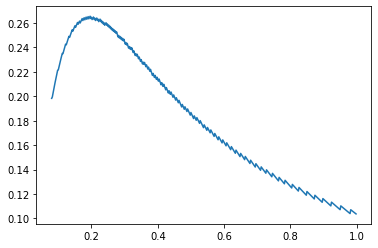

In [10]:
plt.plot(Propeller['x'], Propeller['y'])

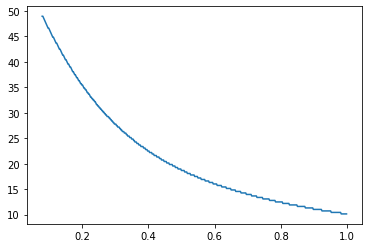

In [12]:
plt.plot(Propeller['x'], Propeller['theta (°)'])